In [1]:
import os
import pandas
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [80]:
# Custom Dataset
class DetectDataset(Dataset):
    def __init__(self, labels_dir, img_dir, transform=None, target_transform=None):
        self.labels_dir = labels_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))
        label = self._load_label(label_path)
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    
    # Helper function to get label from images
    def _load_label(self, label_path):
        # parse the label path and read files
        with open(label_path, 'r') as file:
            boxes = []
            for line in file.readlines():
                # Grab label variables from file
                class_id, x_center, y_center, width, height = map(float, line.strip().split()) # returns list of float from split line
                boxes.append([class_id, x_center, y_center, width, height])
        return torch.tensor(boxes)

In [81]:
# Variable Length Data: Each image can have a different number of bounding boxes. 
# The default collate_fn tries to stack everything into tensors, which fails if they have different shapes.

# Stack images into tensors but not targets to avoid this conflict
def collate_fn(batch):
    images = []
    targets = []
    for sample in batch:
        images.append(sample[0])
        targets.append(sample[1])
    images = torch.stack(images, dim=0)
    return images, targets

In [82]:
# class IDs
classes = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

In [83]:
train_labels_dir = "../data/VehiclesDetectionDataset/train/labels/"
train_img_dir = "../data/VehiclesDetectionDataset/train/images/"
test_labels_dir = "../data/VehiclesDetectionDataset/test/labels/"
test_img_dir = "../data/VehiclesDetectionDataset/test/images/"

In [84]:
# calculate mean and std of images


In [85]:
# Define transformations (optional)
transform = transforms.Compose([
    transforms.ToTensor()
])

In [86]:
trainset = DetectDataset(train_labels_dir, train_img_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [87]:
testset = DetectDataset(test_labels_dir, test_img_dir, transform=transform)
# issue with torch.stack when batch > 1
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=True)

In [88]:
train_features, train_labels = next(iter(trainloader))

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [66]:
train_features

tensor([[[[0.1216, 0.1569, 0.1922,  ..., 0.3882, 0.3451, 0.2431],
          [0.1725, 0.1490, 0.1373,  ..., 0.4196, 0.4157, 0.3569],
          [0.3569, 0.2980, 0.2039,  ..., 0.4078, 0.4549, 0.4510],
          ...,
          [0.5216, 0.4549, 0.3882,  ..., 0.4235, 0.4353, 0.3922],
          [0.5647, 0.5333, 0.4314,  ..., 0.4392, 0.3922, 0.4314],
          [0.5882, 0.5922, 0.4824,  ..., 0.4941, 0.3765, 0.4588]],

         [[0.1059, 0.1412, 0.1765,  ..., 0.4275, 0.3725, 0.2706],
          [0.1569, 0.1333, 0.1216,  ..., 0.4588, 0.4431, 0.3843],
          [0.3490, 0.2902, 0.1961,  ..., 0.4353, 0.4824, 0.4784],
          ...,
          [0.5490, 0.4824, 0.4157,  ..., 0.3961, 0.4078, 0.3647],
          [0.5882, 0.5608, 0.4588,  ..., 0.4118, 0.3647, 0.4039],
          [0.6118, 0.6196, 0.5098,  ..., 0.4667, 0.3490, 0.4314]],

         [[0.1098, 0.1451, 0.1804,  ..., 0.3961, 0.3451, 0.2431],
          [0.1608, 0.1373, 0.1255,  ..., 0.4275, 0.4157, 0.3569],
          [0.3608, 0.3020, 0.2000,  ..., 0

In [67]:
train_labels

[{'boxes': tensor([[0.5096, 0.6058, 0.8798, 0.5180]]), 'labels': tensor([2])},
 {'boxes': tensor([[0.1382, 0.7368, 0.2764, 0.5216],
          [0.3798, 0.5048, 0.0553, 0.0793]]),
  'labels': tensor([2, 2])},
 {'boxes': tensor([[0.4748, 0.4880, 0.8233, 0.9026]]), 'labels': tensor([4])},
 {'boxes': tensor([[0.5072, 0.5228, 0.9796, 0.5877],
          [0.8413, 0.2885, 0.3137, 0.2332]]),
  'labels': tensor([2, 2])}]

Class ID: 2
Box Coordinates: 0.5096153616905212
Box Coordinates: 0.6057692170143127
Box Coordinates: 0.879807710647583
Box Coordinates: 0.5180288553237915
torch.Size([416, 416, 3])


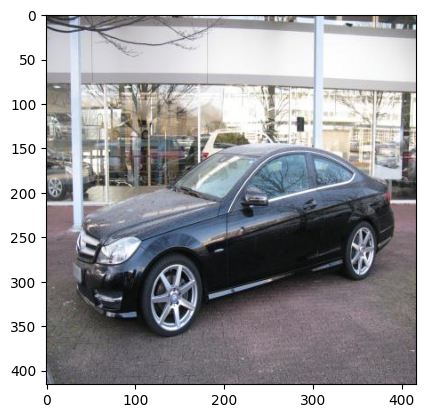

In [68]:
print(f"Class ID: {train_labels[0]['labels'][0]}")
for box in train_labels[0]['boxes'][0]: print(f"Box Coordinates: {box}")
img = train_features[0]
img = img.permute(1, 2, 0)
print(img.shape)
plt.imshow(img)
plt.show()

In [69]:
# Convert tensor image to correct openCV image format
def tensor_to_cv2_image(tensor):
    # Convert GPU tensor to CPU based
    image = tensor.cpu().numpy() 
    image = (image * 255) # convert to unnormalized pixel values
    image = np.ascontiguousarray(image, np.uint8)
    return image

# Draw boxes on image
def draw_boxes(image, boxes, labels):
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = map(int, box)
        cv.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv.putText(image, str(int(label)), (x_min, y_min - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

In [70]:
# Convert image tensor to openCV image
image = tensor_to_cv2_image(img)
print("Image Type:", image.shape)

target = train_labels[0]
boxes = target['boxes']
labels = target['labels']

# Draw box on image
image = draw_boxes(image, boxes, labels)

Image Type: (416, 416, 3)


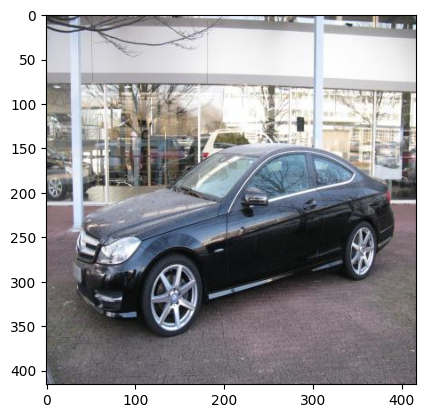

In [71]:
plt.imshow(image)

# BUG!!!
- Box coordinates are incorrect most likely due to the many transformations of the images

In [ ]:
# SAVE FOR LATER
    # Convert normalized coordinates to pixel coordinates
    # x_center *= image.width
    # y_center *= image.height
    # width *= image.width
    # height *= image.height
    
    # # Calculate bounding box corners
    # x_min = x_center - width / 2
    # y_min = y_center - height / 2
    # x_max = x_center + width / 2
    # y_max = y_center + height / 2
    
    # boxes.append([x_min, y_min, x_max, y_max])